In [1]:
!pip install traker[fast]
!pip install transformers
!pip install datasets
!pip install torch torchvision torchaudio

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fast_jl: filename=fast_jl-0.1.3-cp310-cp310-linux_x86_64.whl size=971505 sha256=7d8ac64cbeebdab81ff2f81a48091feaa62ec76821d4826921a071b0b357cb89
  Stored in directory: /root/.cache/pip/wheels/c0/5e/37/3a9d828d49fbbcb9ba54a11d3b48a5a5ac627bd8beb46bf05b
  Created wheel for traker: filename=traker-0.3.2-py3-none-any.whl size=28986 sha256=8fe8b7dfdc20745a3a433a0a082775f13e369617f5b3f599200f6b1c5d593c0f
  Stored in directory: /root/.cache/pip/wheels/2a/bb/be/1e35e69a11e1aba84adfedeae2691798134199591cfe6d4f4e
Successfully built fast_jl traker
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from argparse import ArgumentParser
from tqdm import tqdm
from pathlib import Path

import torch as ch
import torch.nn as nn
from torch.utils.data import DataLoader

from trak import TRAKer

# Huggingface imports
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    default_data_collator,
)

# Configuration
GLUE_TASK_TO_KEYS = {
    "qnli": ("question", "sentence"),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}


# Adjust dataset size as needed for Colab
TRAIN_SET_SIZE = 50_000  # Reduced for Colab memory constraints
VAL_SET_SIZE = 5_463


class SequenceClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.config = AutoConfig.from_pretrained(
            "bert-base-cased",
            num_labels=2,
            finetuning_task="qnli",
            attn_implementation="eager",
        )

        self.model = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-cased", config=self.config, ignore_mismatched_sizes=False
        )

        # Check if GPU is available
        self.device = "cuda" if ch.cuda.is_available() else "cpu"
        self.model.eval().to(self.device)

    def forward(self, input_ids, token_type_ids, attention_mask):
        return self.model(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        ).logits


def get_dataset(split, inds=None):
    raw_datasets = load_dataset("glue", "qnli")
    sentence1_key, sentence2_key = GLUE_TASK_TO_KEYS["qnli"]

    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

    def preprocess_function(examples):
        args = (examples[sentence1_key], examples[sentence2_key])
        return tokenizer(*args, padding="max_length", max_length=128, truncation=True)

    raw_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        desc="Running tokenizer on dataset",
    )

    if split == "train":
        ds = raw_datasets["train"]
    else:
        ds = raw_datasets["validation"]
    return ds


def init_model(ckpt_path=None):
    model = SequenceClassificationModel()
    if ckpt_path and os.path.exists(ckpt_path):
        sd = ch.load(ckpt_path, map_location=model.device)
        model.model.load_state_dict(sd)
    return model


def init_loaders(batch_size=16):
    ds_train = get_dataset("train").select(range(TRAIN_SET_SIZE))
    ds_val = get_dataset("val").select(range(VAL_SET_SIZE))
    return (
        DataLoader(
            ds_train,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=default_data_collator,
        ),
        DataLoader(
            ds_val,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=default_data_collator,
        ),
    )


def process_batch(batch, device):
    return [
        x.to(device)
        for x in [
            batch["input_ids"],
            batch["token_type_ids"],
            batch["attention_mask"],
            batch["labels"],
        ]
    ]


def main():
    # Create output directory in Colab
    save_dir = Path("/content/trak_output")
    save_dir.mkdir(exist_ok=True)

    # Detect device
    device = "cuda" if ch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Initialize model and data loaders
    loader_train, loader_val = init_loaders()
    model = init_model()

    traker = TRAKer(
        model=model,
        task="text_classification",
        train_set_size=TRAIN_SET_SIZE,
        save_dir=save_dir,
        device=device,
        proj_dim=1024,
    )

    # Start TRAK analysis
    traker.load_checkpoint(model.state_dict(), model_id=0)

    print("Featurizing training data...")
    for batch in tqdm(loader_train):
        batch = process_batch(batch, device)
        traker.featurize(batch=batch, num_samples=batch[0].shape[0])

    traker.finalize_features()

    print("Scoring validation data...")
    traker.start_scoring_checkpoint(
        exp_name="qnli",
        checkpoint=model.state_dict(),
        model_id=0,
        num_targets=VAL_SET_SIZE,
    )

    for batch in tqdm(loader_val):
        batch = process_batch(batch, device)
        traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name="qnli")
    print("Analysis complete! Results saved to:", save_dir)
    return scores

Using device: cuda


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/872k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/877k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Running tokenizer on dataset:   0%|          | 0/104743 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5463 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5463 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5463 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:STORE:No existing model IDs in /content/trak_output.
INFO:STORE:No existing TRAK scores in /content/trak_output.


Featurizing training data...


Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Scoring validation data...


Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
INFO:STORE:Saving scores in /content/trak_output/scores/qnli.mmap


Analysis complete! Results saved to: /content/trak_output
Visualizing TRAK scores and examples...

Target Example (Validation Index 5061):
Question: Where did Jebe die?
Sentence: Genghis Khan recalled Subutai back to Mongolia soon afterwards, and Jebe died on the road back to Samarkand.
Label: Not Entailment

Most Influential Training Examples:

1. Training Example (Index 4749, TRAK Score: 0.0007):
Question: How many shares of berkshire hathway was pledged as a donation
Sentence: On June 25, 2006, Warren Buffett (then the world's richest person, estimated worth of US$62 billion as of April 16, 2008) pledged to give the foundation approximately 10 million Berkshire Hathaway Class B shares spread over multiple years through annual contributions, with the first year's donation of 500,000 shares being worth approximately US$1.5 billion.
Label: Not Entailment

2. Training Example (Index 4512, TRAK Score: 0.0007):
Question: What year was the movie Frozen released?
Sentence: For example, for 

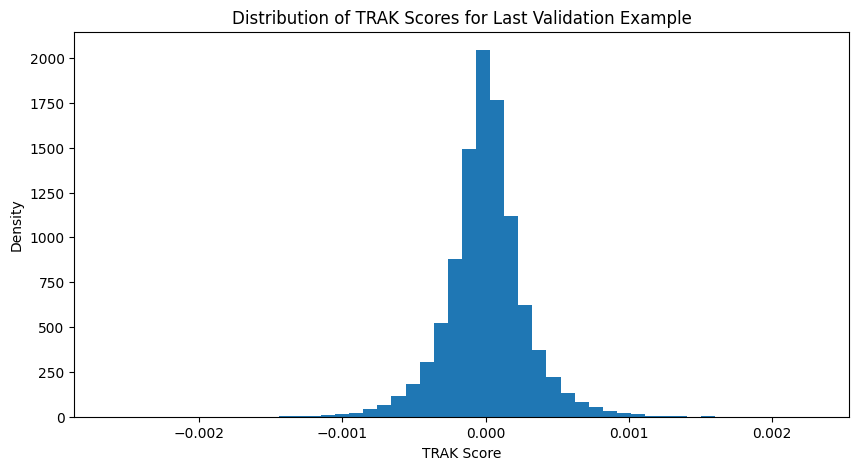

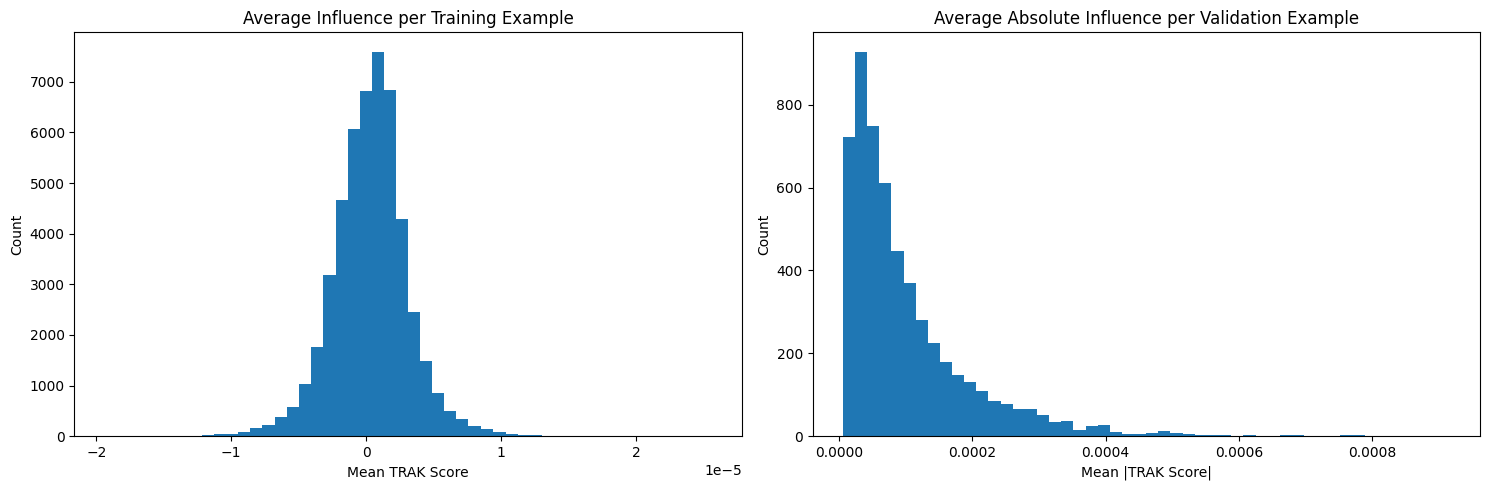

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch


def visualize_trak_examples(scores, n_examples=3):
    """
    Visualize examples with their most influential training examples according to TRAK scores
    """
    # Load the raw text data
    raw_datasets = load_dataset("glue", "qnli")
    train_data = raw_datasets["train"]
    val_data = raw_datasets["validation"]

    # Get random validation examples to visualize
    rng = np.random.RandomState(42)
    val_indices = rng.choice(VAL_SET_SIZE, n_examples, replace=False)

    for val_idx in val_indices:
        # Get target example
        target_example = val_data[int(val_idx)]
        target_q = target_example["question"]
        target_s = target_example["sentence"]
        target_label = (
            "Entailment" if target_example["label"] == 1 else "Not Entailment"
        )

        print("\n" + "=" * 80)
        print(f"Target Example (Validation Index {val_idx}):")
        print(f"Question: {target_q}")
        print(f"Sentence: {target_s}")
        print(f"Label: {target_label}")
        print("\nMost Influential Training Examples:")

        # Get top 5 most influential training examples
        train_scores = scores[:TRAIN_SET_SIZE, val_idx]
        top_train_indices = torch.topk(torch.tensor(train_scores), k=5).indices

        for i, train_idx in enumerate(top_train_indices, 1):
            train_example = train_data[int(train_idx)]
            score = train_scores[int(train_idx)]
            q = train_example["question"]
            s = train_example["sentence"]
            label = "Entailment" if train_example["label"] == 1 else "Not Entailment"

            print(
                f"\n{i}. Training Example (Index {train_idx}, TRAK Score: {score:.4f}):"
            )
            print(f"Question: {q}")
            print(f"Sentence: {s}")
            print(f"Label: {label}")

    # Plot score distribution for this validation example
    plt.figure(figsize=(10, 5))
    plt.hist(train_scores, bins=50, density=True)
    plt.title(f"Distribution of TRAK Scores for Last Validation Example")
    plt.xlabel("TRAK Score")
    plt.ylabel("Density")
    plt.show()

    # Plot overall statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Average influence per training example
    mean_influence = scores.mean(axis=1)
    ax1.hist(mean_influence, bins=50)
    ax1.set_title("Average Influence per Training Example")
    ax1.set_xlabel("Mean TRAK Score")
    ax1.set_ylabel("Count")

    # Average absolute influence per validation example
    mean_abs_influence = np.abs(scores).mean(axis=0)
    ax2.hist(mean_abs_influence, bins=50)
    ax2.set_title("Average Absolute Influence per Validation Example")
    ax2.set_xlabel("Mean |TRAK Score|")
    ax2.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


# Call the visualization function with the TRAK scores
if __name__ == "__main__":
    scores = main()
    print("Visualizing TRAK scores and examples...")
    visualize_trak_examples(scores)